In [1]:
import os
import glob
import numpy as np
import librosa
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

In [2]:
DATA_PATH = "C:/Users/joshd/Documents/BTech Project Sem-7/btech_project/audio_emotion_detection/RAVDESS_audio_dataset"
SR = 22050
N_MFCC = 40
MAX_PAD_LEN = 174
BATCH_SIZE = 32
EPOCHS = 40
TEST_SIZE = 0.2
RANDOM_STATE = 42
MODEL_OUT = "audio_emotion_CNN_model.h5"

In [3]:
EMOTIONS = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [4]:
def extract_emotion_from_filename(filename):
    base = os.path.basename(filename)
    parts = base.split('.')[0].split('-')
    if len(parts) < 3:
        return None
    emo_code = parts[2]
    return EMOTIONS.get(emo_code)

def pad_or_truncate(mfcc, max_len=MAX_PAD_LEN):
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0,0),(0,pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc

In [5]:
def extract_features(file_path, sr=SR, n_mfcc=N_MFCC, max_pad_len=MAX_PAD_LEN):
    try:
        y, sr = librosa.load(file_path, sr=sr)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    stacked = np.vstack([mfcc, delta, delta2])
    stacked = pad_or_truncate(stacked, max_pad_len)
    return stacked

In [6]:
def load_dataset(data_path):
    pattern = os.path.join(data_path, '**', '*.wav')
    files = glob.glob(pattern, recursive=True)
    print(f"Found {len(files)} wav files.")
    X, Y = [], []
    for f in files:
        emo = extract_emotion_from_filename(f)
        if emo is None:
            continue
        feat = extract_features(f)
        if feat is None:
            continue
        X.append(feat)
        Y.append(emo)
    X = np.array(X)
    Y = np.array(Y)
    print("X shape (num_samples, features, time):", X.shape)
    return X, Y

In [7]:
# ---------------- MODEL ----------------
def build_cnn_model(input_shape, num_classes):
    inp = layers.Input(shape=(input_shape[0], input_shape[1], 1))
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [8]:
# ---------------- PLOTS ----------------
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-8)
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        val = f"{cm[i, j]:.2f}" if normalize else f"{int(cm[i, j])}"
        plt.text(j, i, val,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

Found 2880 wav files.
X shape (num_samples, features, time): (2880, 120, 174)
Train shape: (2304, 120, 174, 1) (2304, 8)
Test shape: (576, 120, 174, 1) (576, 8)
Class weights: {0: np.float64(0.935064935064935), 1: np.float64(0.9381107491856677), 2: np.float64(0.9381107491856677), 3: np.float64(0.9381107491856677), 4: np.float64(0.9381107491856677), 5: np.float64(1.87012987012987), 6: np.float64(0.9381107491856677), 7: np.float64(0.9381107491856677)}


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 174, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 120, 174, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 120, 174, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 87, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 60, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 43, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 43, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,112 (434.03 KB)

 Trainable params: 110,664 (432.28 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.2103 - loss: 1.9758

65/65 ━━━━━━━━━━━━━━━━━━━━ 31s 413ms/step - accuracy: 0.2629 - loss: 1.8790 - val_accuracy: 0.1515 - val_loss: 2.0878
Epoch 2/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.3581 - loss: 1.6531

65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 385ms/step - accuracy: 0.3912 - loss: 1.5944 - val_accuracy: 0.2165 - val_loss: 1.8495
Epoch 3/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.4770 - loss: 1.4190

65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 395ms/step - accuracy: 0.4790 - loss: 1.4226 - val_accuracy: 0.2771 - val_loss: 1.7767
Epoch 4/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 402ms/step - accuracy: 0.5379 - loss: 1.2583 - val_accuracy: 0.1991 - val_loss: 2.0125
Epoch 5/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.5703 - loss: 1.1843

65/65 ━━━━━━━━━━━━━━━━━━━━ 31s 255ms/step - accuracy: 0.5876 - loss: 1.1436 - val_accuracy: 0.3506 - val_loss: 1.6684
Epoch 6/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.6126 - loss: 1.1088

65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 256ms/step - accuracy: 0.6353 - loss: 1.0426 - val_accuracy: 0.4632 - val_loss: 1.3991
Epoch 7/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 254ms/step - accuracy: 0.6831 - loss: 0.8928 - val_accuracy: 0.4329 - val_loss: 1.4414
Epoch 8/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.7423 - loss: 0.8055

65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 264ms/step - accuracy: 0.7424 - loss: 0.7881 - val_accuracy: 0.5455 - val_loss: 1.0948
Epoch 9/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.7669 - loss: 0.6893

65/65 ━━━━━━━━━━━━━━━━━━━━ 18s 275ms/step - accuracy: 0.7728 - loss: 0.6647 - val_accuracy: 0.5887 - val_loss: 1.0914
Epoch 10/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 254ms/step - accuracy: 0.8148 - loss: 0.5671 - val_accuracy: 0.5584 - val_loss: 1.0926
Epoch 11/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.8406 - loss: 0.5078

65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 253ms/step - accuracy: 0.8427 - loss: 0.5033 - val_accuracy: 0.6364 - val_loss: 0.9843
Epoch 12/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.8990 - loss: 0.3808

65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 263ms/step - accuracy: 0.8852 - loss: 0.4003 - val_accuracy: 0.6753 - val_loss: 0.9090
Epoch 13/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 256ms/step - accuracy: 0.9021 - loss: 0.3207 - val_accuracy: 0.3983 - val_loss: 2.1553
Epoch 14/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 251ms/step - accuracy: 0.9276 - loss: 0.2706 - val_accuracy: 0.6104 - val_loss: 1.1540
Epoch 15/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9435 - loss: 0.2152

65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 258ms/step - accuracy: 0.9455 - loss: 0.2202 - val_accuracy: 0.8139 - val_loss: 0.5686
Epoch 16/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 18s 276ms/step - accuracy: 0.9638 - loss: 0.1639 - val_accuracy: 0.6277 - val_loss: 1.0477
Epoch 17/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9678 - loss: 0.1390

65/65 ━━━━━━━━━━━━━━━━━━━━ 18s 282ms/step - accuracy: 0.9720 - loss: 0.1357 - val_accuracy: 0.9091 - val_loss: 0.2687
Epoch 18/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 259ms/step - accuracy: 0.9807 - loss: 0.1024 - val_accuracy: 0.7316 - val_loss: 0.7186
Epoch 19/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 256ms/step - accuracy: 0.9884 - loss: 0.0763 - val_accuracy: 0.8745 - val_loss: 0.3451
Epoch 20/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 258ms/step - accuracy: 0.9884 - loss: 0.0726 - val_accuracy: 0.8658 - val_loss: 0.4721
Epoch 21/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 256ms/step - accuracy: 0.9904 - loss: 0.0617 - val_accuracy: 0.8009 - val_loss: 0.5965
Epoch 22/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 256ms/step - accuracy: 0.9947 - loss: 0.0500 - val_accuracy: 0.8225 - val_loss: 0.4975
Epoch 23/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 253ms/step - accuracy: 0.9923 - loss: 0.0509 - val_accuracy: 0.7922 - val_loss: 0.6542
Test loss: 0.2177, Test accuracy: 0.9392
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Classification report

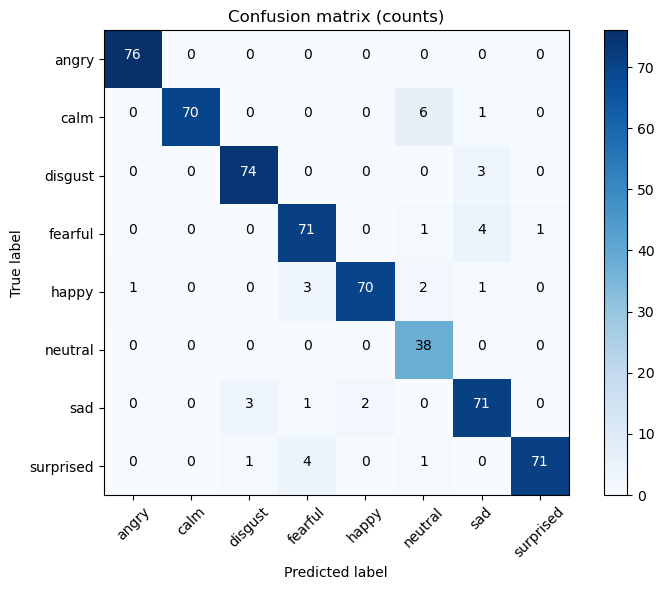

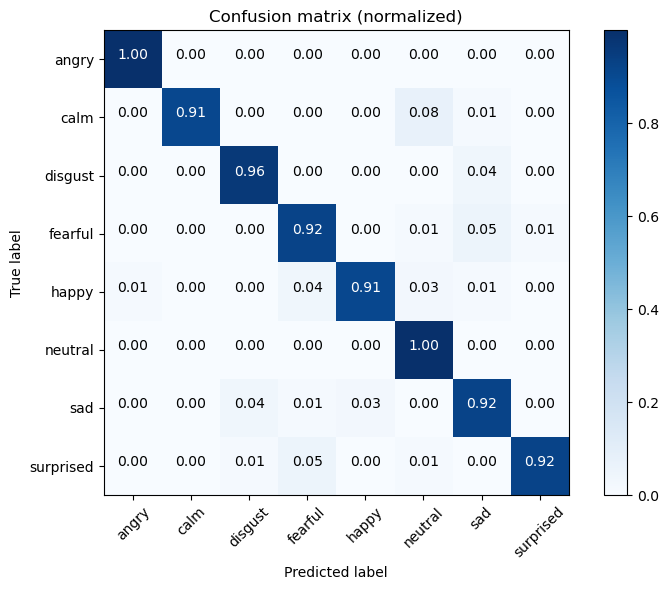

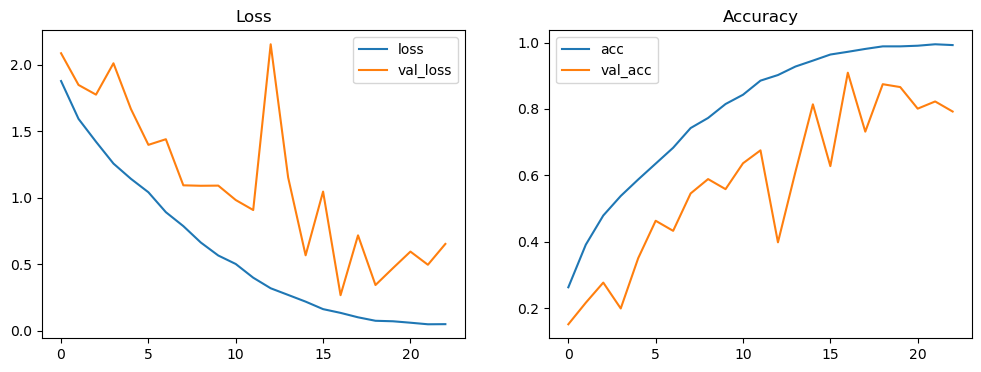

In [9]:
# ---------------- MAIN ----------------
def main():
    X, Y = load_dataset(DATA_PATH)
    X = X[..., np.newaxis]

    le = LabelEncoder()
    y_encoded = le.fit_transform(Y)
    num_classes = len(le.classes_)
    y_cat = tf.keras.utils.to_categorical(y_encoded, num_classes=num_classes)

    X_train, X_test, y_train, y_test, y_train_labels, y_test_labels = train_test_split(
        X, y_cat, y_encoded, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_encoded
    )

    print("Train shape:", X_train.shape, y_train.shape)
    print("Test shape:", X_test.shape, y_test.shape)

    # class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_labels),
        y=y_train_labels
    )
    class_weights = dict(enumerate(class_weights))
    print("Class weights:", class_weights)

    # build model
    input_shape = (X.shape[1], X.shape[2])
    model = build_cnn_model((input_shape[0], input_shape[1]), num_classes)
    model.summary()

    cb = [
        callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
        callbacks.ModelCheckpoint(MODEL_OUT, save_best_only=True, monitor='val_loss')
    ]

    history = model.fit(
        X_train,
        y_train,
        validation_split=0.1,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=cb,
        verbose=1,
        class_weight=class_weights  # <-- FIX APPLIED
    )

    # evaluate
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test loss: {loss:.4f}, Test accuracy: {acc:.4f}")

    # predictions
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    print("Classification report:")
    print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

    cm = confusion_matrix(y_true_labels, y_pred_labels)
    plot_confusion_matrix(cm, classes=le.classes_, normalize=False, title='Confusion matrix (counts)')
    plot_confusion_matrix(cm, classes=le.classes_, normalize=True, title='Confusion matrix (normalized)')

    # plot history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend(); plt.title('Loss')
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.legend(); plt.title('Accuracy')
    plt.show()

    # save label encoder for inference
    import joblib
    joblib.dump(le, "emotion_audio_label_encoder.pkl")

# ---------------- INFERENCE ----------------
def predict_emotion(file_path, model_path=MODEL_OUT, le_path="label_encoder.pkl"):
    import joblib
    le = joblib.load(le_path)
    model = tf.keras.models.load_model(model_path)

    feat = extract_features(file_path)
    if feat is None:
        return None
    feat = feat[np.newaxis, ..., np.newaxis]  # shape (1, features, time, 1)

    pred = model.predict(feat)
    pred_label = np.argmax(pred, axis=1)[0]
    emotion = le.inverse_transform([pred_label])[0]
    return emotion

if __name__ == "__main__":
    main()